# **SAM2**

In [2]:
!nvidia-smi

Mon Aug 26 16:51:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
     

!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

HOME: /kaggle/working
Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510 (from 1)
Receiving objects: 100% (510/510), 88.46 MiB | 35.69 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/kaggle/working/segment-anything-2
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no g++ version bounds defined for CUDA version 12.3
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Emitting ninja build file /kaggle/working/segment-anything-2/build/temp.linux-x86_64-cpython-310/build.ninja...
Compiling objects...
Allowing ninja to set a defa

In [38]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
     

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [8]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [10]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)
'''def show_mask(mask, ax, random_color=False, borders=True):
    # Generate random color if required
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Light blue color with transparency
    
    # Get the height and width of the mask
    h, w = mask.shape[-2:]
    
    # Ensure mask is binary
    mask = mask.astype(np.uint8)
    
    # Create a mask image with the specified color
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    # Draw contours if borders are enabled
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        # Draw contours on the mask image
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    
    # Display the mask image
    ax.imshow(mask_image)
    ax.axis('off')  # Hide the axes
    '''

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

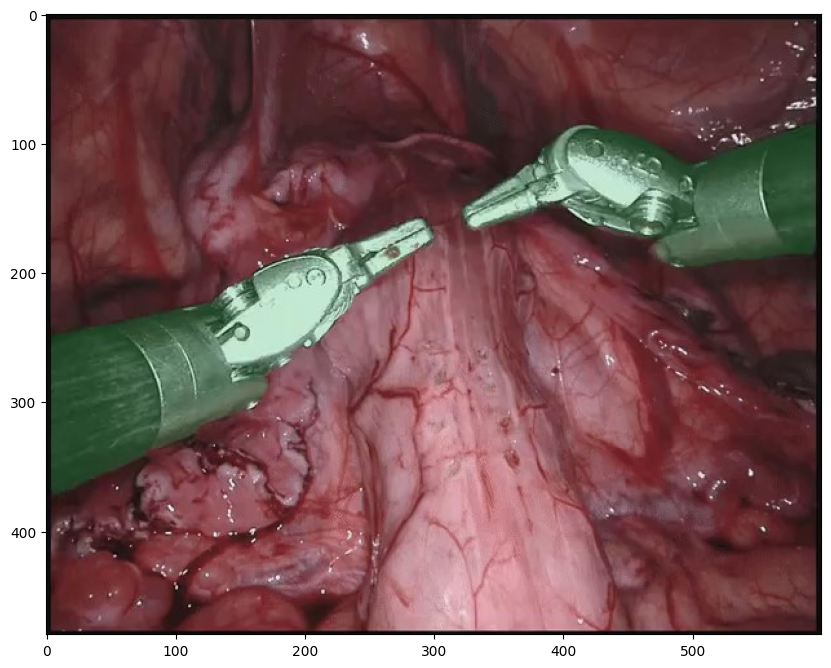

In [12]:
image = Image.open('/kaggle/input/endovis2017-data/ezgif-5-52c5bf5f66 - frame at 0m0s.jpg')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [13]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

/kaggle/working/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [15]:
predictor.set_image(image)

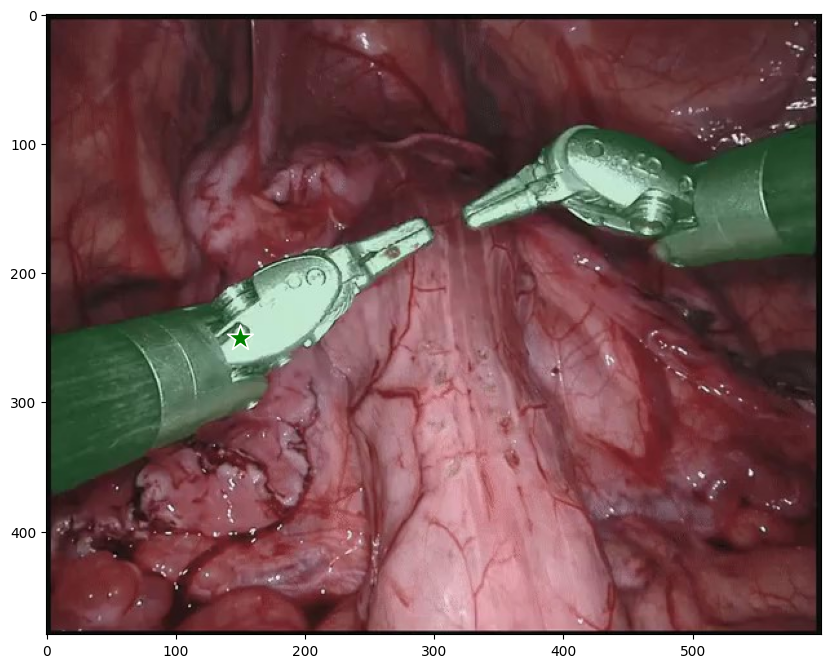

In [16]:
input_point = np.array([[150, 250]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [17]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [18]:
import cv2

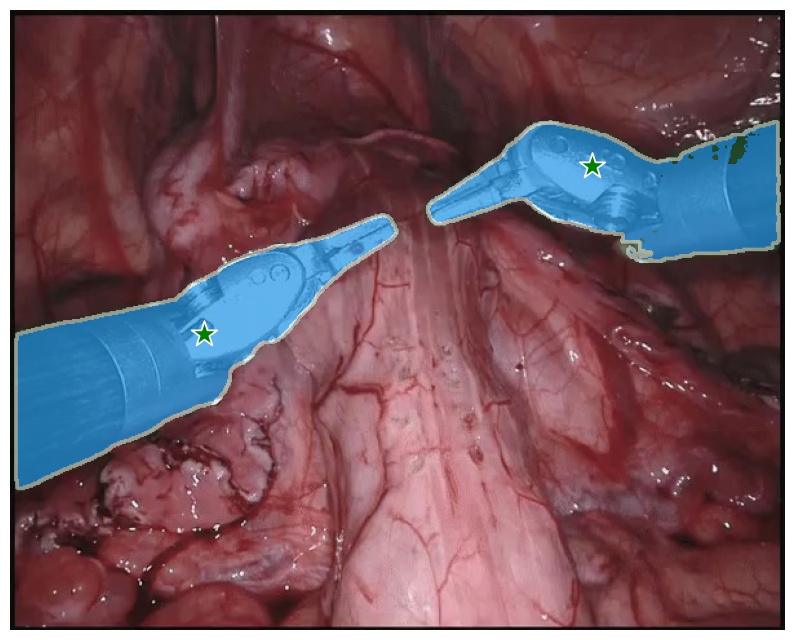

In [19]:
#for multiple identifications
input_point = np.array([[150, 250], [450, 120]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape
(1, 1200, 1800)
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

In [20]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


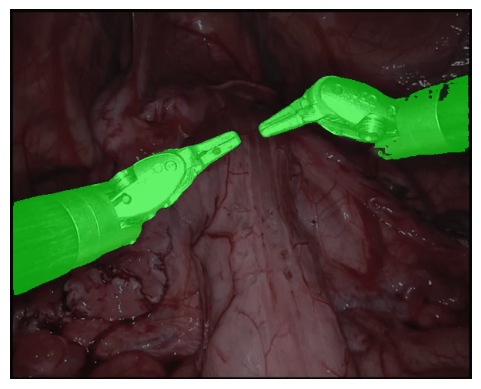

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, image):
    # Ensure mask is binary
    mask_binary = (mask > 0).astype(np.uint8)
    
    # Convert image to RGB if it's not
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Convert mask to color (for better visualization)
    mask_colored = np.zeros_like(image)
    mask_colored[mask_binary > 0] = [0, 255, 0]  # Green mask
    
    # Overlay mask on the image
    ax.imshow(mask_colored, alpha=0.5)

    # Hide axes
    ax.axis('off')

    # Show the plot
    plt.show()

# Example usage
local_image_path = '/kaggle/input/endovis2017-data/ezgif-5-52c5bf5f66 - frame at 0m0s.jpg'
image_source = Image.open(local_image_path)
image_source_np = np.array(image_source)

# Assuming masks is a NumPy array with shape (number_of_masks, H, W)
mask = masks[0]  # Extract the first mask
show_mask(mask, image_source_np)

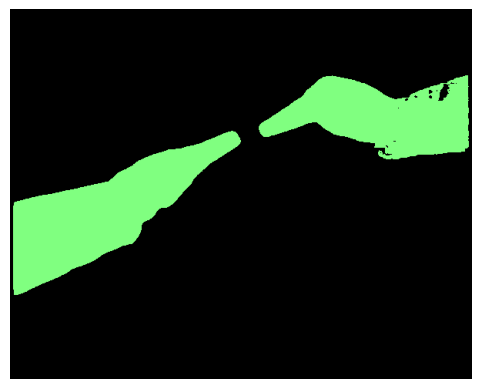

In [23]:
annotated_frame = masks[0]
annotated_frame_with_mask= show_mask(masks[0], annotated_frame)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_masked_image(mask, image):
    # Ensure mask is binary
    mask_binary = (mask > 0).astype(np.uint8)
    
    # Convert image to RGB if it's not
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Create a copy of the image
    annotated_image = image.copy()
    
    # Create colored mask (green in this case)
    mask_colored = np.zeros_like(image)
    mask_colored[mask_binary > 0] = [0, 255, 0]  # Green mask
    
    # Overlay mask on the image
    cv2.addWeighted(annotated_image, 1, mask_colored, 0.5, 0, annotated_image)
    
    return annotated_image

def show_mask(mask, image):
    annotated_image = create_masked_image(mask, image)
    
    # Create a figure and axes
    fig, ax = plt.subplots()
    # Display the annotated image
    ax.imshow(annotated_image)
    # Hide axes
    ax.axis('off')
    # Show the plot
    plt.show()
    
    return annotated_image

# Example usage
local_image_path = '/kaggle/input/endovis2017-data/ezgif-5-52c5bf5f66 - frame at 0m0s.jpg'
image_source = Image.open(local_image_path)
image_source_np = np.array(image_source)

# Assuming masks is a NumPy array with shape (number_of_masks, H, W)
mask = masks[0]  # Extract the first mask

# Show the mask (this will display the plot)
show_mask(mask, image_source_np)

# Create the annotated image
annotated_frame_with_mask = create_masked_image(masks[0], image_source_np)

# Convert numpy array to PIL Image
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

# Save the image
annotated_frame_with_mask_pil.save('/kaggle/working/image_pil_mask.jpg')

In [25]:
def create_binary_mask(mask):
    # Ensure mask is binary
    mask_binary = (mask > 0).astype(np.uint8)
    
    # Create a black background
    binary_mask = np.zeros_like(mask_binary)
    
    # Set masked areas to white (255)
    binary_mask[mask_binary > 0] = 255
    
    return binary_mask

# Then use it like this:
binary_mask = create_binary_mask(masks[0])
Image.fromarray(binary_mask).save('/kaggle/working/binary_mask.png')

# **Cutie**

In [26]:
!git clone https://github.com/hkchengrex/Cutie.git

Cloning into 'Cutie'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 596 (delta 165), reused 151 (delta 129), pack-reused 374 (from 1)
Receiving objects: 100% (596/596), 2.83 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (280/280), done.


In [27]:
%cd Cutie
!pip install -e .

/kaggle/working/segment-anything-2/Cutie
Obtaining file:///kaggle/working/segment-anything-2/Cutie
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-install-k18l1bn9/thinplate_2b2c322d690b48c0a519263628ef4bdb
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-install-k18l1bn9/thinplate_2b2c322d690b48c0a519263628ef4bdb
  Resolved https://github.com/cheind/py-thin-plate-spline to commit f6995795397118b7d0ac01aecd3f39ffbfad9dee
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 7.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:

#%cd /kaggle/working/Cutie
!python /kaggle/working/segment-anything-2/Cutie/cutie/utils/download_models.py

100%|█████████████████████████████████████| 40.7M/40.7M [00:01<00:00, 37.4MiB/s]
100%|███████████████████████████████████████| 140M/140M [00:03<00:00, 44.5MiB/s]


In [29]:
%cd /kaggle/working/Cutie

from os import path
import logging
from omegaconf import DictConfig
import hydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import open_dict
from hydra import compose, initialize

import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from cutie.inference.data.vos_test_dataset import VOSTestDataset
from cutie.inference.data.burst_test_dataset import BURSTTestDataset
from cutie.model.cutie import CUTIE
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.results_utils import ResultSaver, make_zip
from cutie.inference.utils.burst_utils import BURSTResultHandler
from cutie.inference.utils.args_utils import get_dataset_cfg

from tqdm import tqdm
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

# Clear any existing Hydra instances
GlobalHydra.instance().clear()
with torch.inference_mode():
  
  initialize(version_base='1.3.2', config_path="segment-anything-2/Cutie/cutie/config", job_name="eval_config")
  cfg = compose(config_name="eval_config")
  


  with open_dict(cfg):
    cfg['weights'] = './weights/cutie-base-mega.pth' 

  data_cfg = get_dataset_cfg(cfg)

  # Load the network weights
  cutie = CUTIE(cfg).cuda().eval()
  model_weights = torch.load(cfg.weights)
  cutie.load_weights(model_weights)

[Errno 2] No such file or directory: '/kaggle/working/Cutie'
/kaggle/working/segment-anything-2/Cutie


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s] 
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s] 


In [30]:
video_name = '/kaggle/input/endovis2017-data/ezgif-5-52c5bf5f66.mp4'
mask_name = '/kaggle/working/binary_mask.png'

In [31]:
mask = np.array(Image.open('/kaggle/working/binary_mask.png'))
print(np.unique(mask))
num_objects = len(np.unique(mask)) - 1
print(num_objects)

[  0 255]
1


In [34]:
# Remap mask values
mask_remapped = np.zeros_like(mask, dtype=np.uint8)
mask_remapped[mask == 255] = 1  # Assign 1 to the masked area (previously 255)

# Now use mask_remapped instead of mask
mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)

RuntimeError: Class values must be smaller than num_classes.

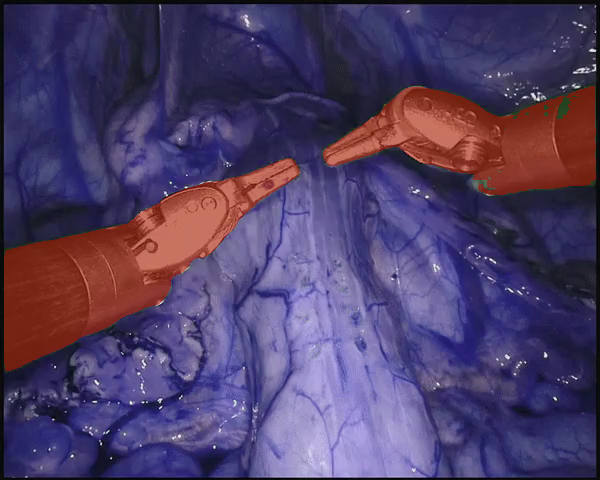

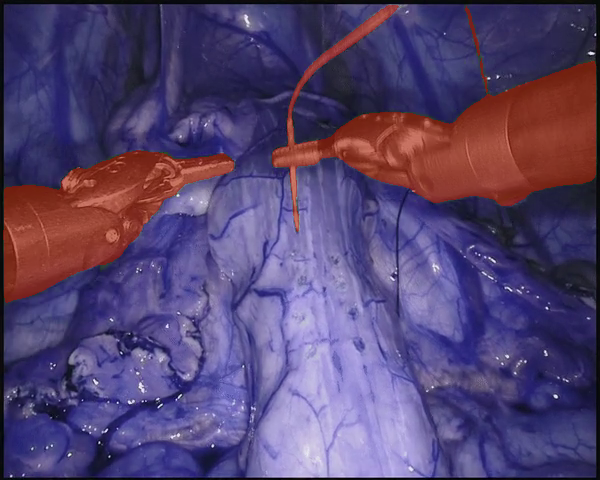

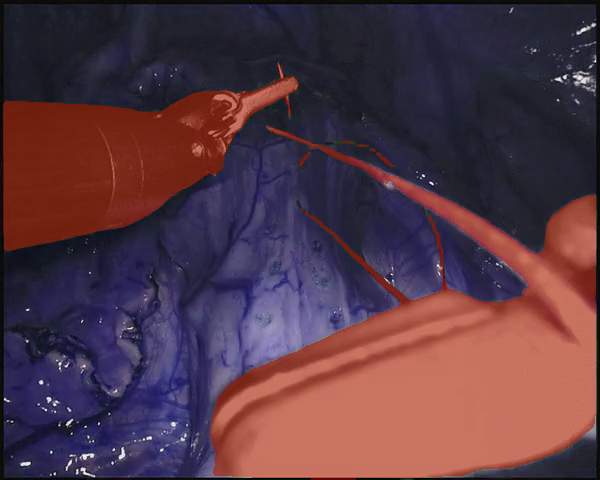

In [33]:
import cv2
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

device = 'cuda'
torch.cuda.empty_cache()

processor = InferenceCore(cutie, cfg=cfg)
cap = cv2.VideoCapture(video_name)

# You can change these two numbers
frames_to_propagate = 200
visualize_every = 20

current_frame_index = 0

with torch.inference_mode():
  with torch.cuda.amp.autocast(enabled=True):
    while (cap.isOpened()):
      # load frame-by-frame
      _, frame = cap.read()
      if frame is None or current_frame_index > frames_to_propagate:
        break

      # convert numpy array to pytorch tensor format
      frame_torch = image_to_torch(frame, device=device)
      if current_frame_index == 0:
    # initialize with the mask
        mask_torch = index_numpy_to_one_hot_torch(mask_remapped, num_objects+1).to(device)
    # the background mask is not fed into the model
        prediction = processor.step(frame_torch, mask_torch[1:], idx_mask=False)
      else:
        # propagate only
        prediction = processor.step(frame_torch)

      # argmax, convert to numpy
      prediction = torch_prob_to_numpy_mask(prediction)

      if current_frame_index % visualize_every == 0:
        visualization = overlay_davis(frame, prediction)
        display(Image.fromarray(visualization))

      current_frame_index += 1

In [35]:
import cv2
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

device = 'cuda'
torch.cuda.empty_cache()

processor = InferenceCore(cutie, cfg=cfg)
cap = cv2.VideoCapture(video_name)

# Get video properties
input_fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_video_name = '/kaggle/working/Sam2+Cutie_output_endovis_video_1.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format

# Calculate output fps if you want to maintain the correct duration
output_fps = input_fps / (frames_to_propagate / visualize_every)
out = cv2.VideoWriter(output_video_name, fourcc, output_fps, (frame_width, frame_height))

current_frame_index = 0

with torch.inference_mode():
    with torch.cuda.amp.autocast(enabled=True):
        while cap.isOpened():
            # Load frame-by-frame
            ret, frame = cap.read()
            if not ret or current_frame_index > frames_to_propagate:
                break

            # Convert numpy array to pytorch tensor format
            frame_torch = image_to_torch(frame, device=device)
            if current_frame_index == 0:
                # Initialize with the mask
                mask_torch = index_numpy_to_one_hot_torch(mask_remapped, num_objects + 1).to(device)
                # The background mask is not fed into the model
                prediction = processor.step(frame_torch, mask_torch[1:], idx_mask=False)
            else:
                # Propagate only
                prediction = processor.step(frame_torch)

            # Argmax, convert to numpy
            prediction = torch_prob_to_numpy_mask(prediction)

            if current_frame_index % visualize_every == 0:
                visualization = overlay_davis(frame, prediction)
                out.write(visualization)  # Write the frame to the output video

            current_frame_index += 1

# Release resources
cap.release()
out.release()

print(f"Video saved as {output_video_name}")

Video saved as /kaggle/working/Sam2+Cutie_output_endovis_video_1.mp4


In [36]:
import cv2
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

device = 'cuda'
torch.cuda.empty_cache()

processor = InferenceCore(cutie, cfg=cfg)
cap = cv2.VideoCapture(video_name)

# Get video properties
input_fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_video_name = '/kaggle/working/Sam2+Cutie_output_endovis_video_2.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format

# Calculate output fps if you want to maintain the correct duration
output_fps = input_fps / (frames_to_propagate / visualize_every)
out = cv2.VideoWriter(output_video_name, fourcc, output_fps, (frame_width, frame_height))

current_frame_index = 0

with torch.inference_mode():
    with torch.cuda.amp.autocast(enabled=True):
        while cap.isOpened():
            # Load frame-by-frame
            ret, frame = cap.read()
            if not ret or current_frame_index > frames_to_propagate:
                break

            # Convert numpy array to pytorch tensor format
            frame_torch = image_to_torch(frame, device=device)
            if current_frame_index == 0:
                # Initialize with the mask
                mask_torch = index_numpy_to_one_hot_torch(mask_remapped, num_objects + 1).to(device)
                # The background mask is not fed into the model
                prediction = processor.step(frame_torch, mask_torch[1:], idx_mask=False)
            else:
                # Propagate only
                prediction = processor.step(frame_torch)

            # Argmax, convert to numpy
            prediction = torch_prob_to_numpy_mask(prediction)

            if current_frame_index % visualize_every == 0:
                visualization = overlay_davis(frame, prediction)
                out.write(visualization)  # Write the frame to the output video

            current_frame_index += 1

# Release resources
cap.release()
out.release()

print(f"Video saved as {output_video_name}")

Video saved as /kaggle/working/Sam2+Cutie_output_endovis_video_2.mp4


# **GUI with GRADIO**

In [42]:
import gradio as gr
import numpy as np
import torch
from PIL import Image
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from cutie.model.cutie import CUTIE
from cutie.inference.inference_core import InferenceCore
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis

# Load SAM2 model
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "/kaggle/input/sam2-hiera-l/sam2_hiera_l.yaml"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Load Cutie model
cutie = CUTIE(cfg).cuda().eval()
model_weights = torch.load(cfg.weights)
cutie.load_weights(model_weights)

def segment_and_propagate(image, x, y):
    # SAM2 segmentation
    predictor.set_image(np.array(image))
    input_point = np.array([[x, y]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    mask = masks[0]
    
    # Create binary mask
    binary_mask = (mask > 0).astype(np.uint8) * 255
    
    # Cutie propagation
    processor = InferenceCore(cutie, cfg=cfg)
    
    # Assuming the input image is the first frame of a video
    # You might need to adjust this part based on your actual video input
    video_name = "/kaggle/input/endovis2017-data/ezgif-5-52c5bf5f66.mp4"
    cap = cv2.VideoCapture(video_name)
    
    frames_to_propagate = 200
    visualize_every = 20
    output_frames = []
    
    current_frame_index = 0
    
    with torch.inference_mode():
        with torch.cuda.amp.autocast(enabled=True):
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret or current_frame_index > frames_to_propagate:
                    break
                
                frame_torch = image_to_torch(frame, device=device)
                if current_frame_index == 0:
                    mask_torch = index_numpy_to_one_hot_torch(binary_mask, 2).to(device)
                    prediction = processor.step(frame_torch, mask_torch[1:], idx_mask=False)
                else:
                    prediction = processor.step(frame_torch)
                
                prediction = torch_prob_to_numpy_mask(prediction)
                
                if current_frame_index % visualize_every == 0:
                    visualization = overlay_davis(frame, prediction)
                    output_frames.append(visualization)
                
                current_frame_index += 1
    
    cap.release()
    
    # Convert output frames to video
    output_video = "/kaggle/working/output_video.mp4"
    height, width, _ = output_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, 30.0, (width, height))
    
    for frame in output_frames:
        out.write(frame)
    
    out.release()
    
    return output_video

iface = gr.Interface(
    fn=segment_and_propagate,
    inputs=[
        gr.Image(type="pil", label="Input Image"),
        gr.Number(label="X Coordinate"),
        gr.Number(label="Y Coordinate")
    ],
    outputs=gr.Video(label="Segmented Video"),
    title="SAM2 + Cutie Segmentation",
    description="Upload an image, provide coordinates, and get a segmented video."
)

iface.launch()

MissingConfigException: Cannot find primary config 'kaggle/input/sam2-hiera-l/sam2_hiera_l.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///kaggle/working/segment-anything-2/Cutie/cutie/config
	provider=schema, path=structured://